In [109]:
import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Model,Sequential
from keras.layers import Input,Dense, Dropout, Activation, Flatten, Reshape
from keras.layers import Conv2D, MaxPooling2D, AveragePooling2D
from keras.layers.pooling import GlobalAveragePooling2D
from keras.layers import Embedding
from keras import regularizers
from keras.losses import mean_squared_error
import glob
import matplotlib.patches as patches
import json
import numpy as np
from matplotlib.path import Path
import dicom
import cv2
import matplotlib.pyplot as plt
%matplotlib inline

The second step of the algorithm is to train a stacked Auto-encoder in order to get the binary mask of the left ventricule inferred shape within the ROI (region of interest output of CNN). It is performed in two steps : pre-training then fine-tuning.

## Open DataSet

Dataset shape : (495, 64, 64, 1) (495, 1, 32, 32)


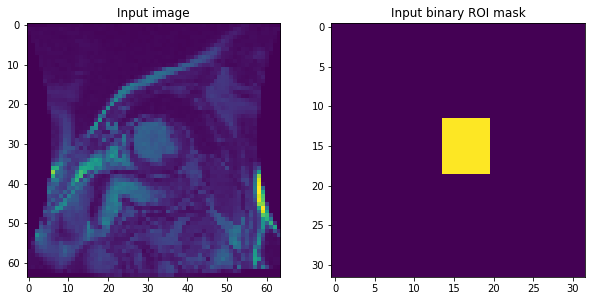

Size for each layer :
Layer, Input Size, Output Size
Conv2D_4 (None, 64, 64, 1) (None, 54, 54, 100)
Average_Pooling2D_4 (None, 54, 54, 100) (None, 9, 9, 100)
Reshape_7 (None, 9, 9, 100) (None, 1, 8100)
Dense_14 (None, 1, 8100) (None, 1, 1024)
Reshape_8 (None, 1, 1024) (None, 1, 32, 32)
Epoch 1/20
495/495 [==============================] - 12s - loss: 0.1801 - acc: 0.1741    
Epoch 2/20
495/495 [==============================] - 11s - loss: 0.1014 - acc: 0.1633    
Epoch 3/20
495/495 [==============================] - 11s - loss: 0.0747 - acc: 0.0696    
Epoch 4/20
495/495 [==============================] - 11s - loss: 0.0587 - acc: 0.0497    
Epoch 5/20
495/495 [==============================] - 11s - loss: 0.0486 - acc: 0.0499    
Epoch 6/20
495/495 [==============================] - 11s - loss: 0.0418 - acc: 0.0512    
Epoch 7/20
495/495 [==============================] - 11s - loss: 0.0374 - acc: 0.0400    
Epoch 8/20
495/495 [==============================] - 11s - loss: 0.0345 - a

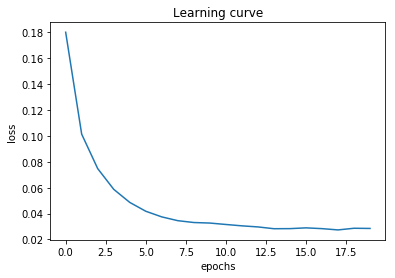

Stored 'y_pred' (ndarray)


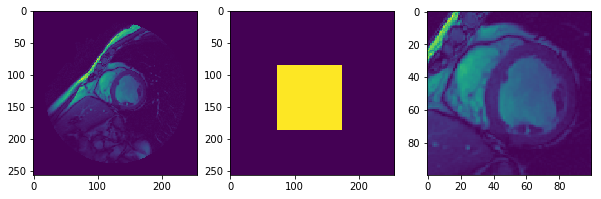

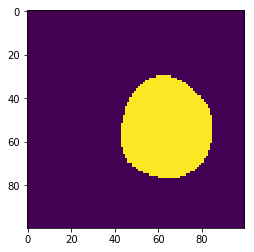

In [112]:
%run 'CNN.ipynb'

## Stacked auto-encoder

### 1rst part : another representation of the ROI with sparse auto-encoder

In [62]:
%store -r y_pred

In [78]:
input_AE = [] #images (100,100)
for j in range(y_pred.shape[0]):
    input_AE.append(cv2.resize(compute_roi_pred(y_pred, j, roi_shape=32)[0],(64 , 64)))
input_AE = np.asarray(input_AE).reshape((-1, 64*64)) #unrolled : 64*64 = vector of 4096 elements

#### Model

In [79]:
from keras import losses
def customized_loss(y_true, y_pred):
    #customize your own loss components
    loss1 = losses.mean_absolute_error(y_true, y_pred)
    loss2 = losses.kullback_leibler_divergence(y_true, y_pred)
    #adjust the weight between loss components
    return 0.0001*0.5 * loss1 + 3 * loss2

In [80]:
model = Sequential()
model.add(Dense(100, kernel_regularizer=regularizers.l2(3*0.001), input_shape=[input_AE.shape[1]]))
model.add(Dense(4096, kernel_regularizer=regularizers.l2(3*0.001)))

In [81]:
for p in model.layers:
    print(p.name, p.input_shape, p.output_shape)

dense_10 (None, 4096) (None, 100)
dense_11 (None, 100) (None, 4096)


#### Training

In [82]:
model.compile(loss= customized_loss,
              optimizer='adam')

In [83]:
h = model.fit(input_AE, input_AE, epochs=100, verbose=2)

Epoch 1/100
1s - loss: 63731.5049
Epoch 2/100
0s - loss: 15324.1381
Epoch 3/100
0s - loss: 11480.5633
Epoch 4/100
0s - loss: 11021.9981
Epoch 5/100
0s - loss: 10966.2075
Epoch 6/100
0s - loss: 10922.2212
Epoch 7/100
0s - loss: 10893.0085
Epoch 8/100
0s - loss: 10884.5405
Epoch 9/100
0s - loss: 10857.3513
Epoch 10/100
0s - loss: 10841.2375
Epoch 11/100
0s - loss: 10804.4372
Epoch 12/100
0s - loss: 10793.5174
Epoch 13/100
0s - loss: 10772.5393
Epoch 14/100
0s - loss: 10764.1552
Epoch 15/100
0s - loss: 10744.0360
Epoch 16/100
0s - loss: 10698.4634
Epoch 17/100
0s - loss: 10623.5922
Epoch 18/100
0s - loss: 10604.2708
Epoch 19/100
0s - loss: 10594.6936
Epoch 20/100
0s - loss: 10599.0197
Epoch 21/100
0s - loss: 10594.6947
Epoch 22/100
0s - loss: 10598.2569
Epoch 23/100
0s - loss: 10594.6949
Epoch 24/100
0s - loss: 10582.0790
Epoch 25/100
0s - loss: 10554.9526
Epoch 26/100
0s - loss: 10547.3217
Epoch 27/100
0s - loss: 10555.2910
Epoch 28/100
0s - loss: 10543.8992
Epoch 29/100
0s - loss: 10544

Text(0.5,0,'epochs')

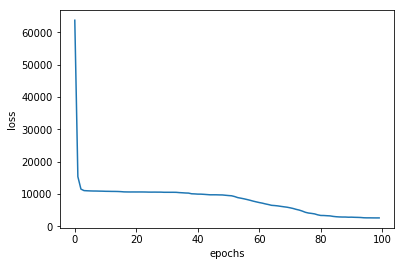

In [84]:
metric = 'loss'
plt.plot(range(len(h.history[metric])), h.history[metric])
plt.ylabel(metric)
plt.xlabel('epochs')

#### Prediction

In [85]:
input_AE_pred = model.predict(input_AE)

In [86]:
pred = input_AE_pred[0].reshape(64, 64)

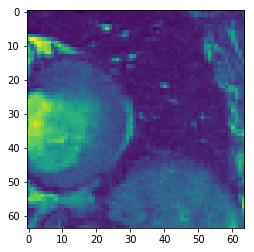

In [87]:
plt.imshow(input_AE[0].reshape(64,64))

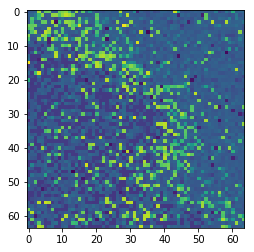

In [88]:
plt.imshow(pred)

### 2nd part : From new representation of ROI to inferred shape using annotated contours

In [120]:
_,_, mask_contour = compute_roi_pred(y_pred, 234)

In [166]:
contour_experts = [] #images (100,100)
for j in range(y_pred.shape[0]):
    contour_experts.append(cv2.resize(compute_roi_pred(y_pred, j)[2], (64,64), interpolation = cv2.INTERSECT_NONE))
contour_experts = np.asarray(contour_experts).reshape((-1, 64*64)) #unrolled : 64*64 = vector of 4096 elements

In [170]:
input_y = contour_experts
input_x = input_AE_pred

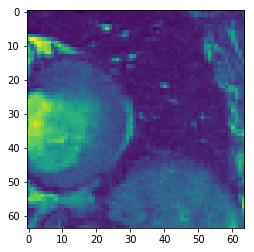

In [188]:
plt.imshow(input_AE[0].reshape(64,64))

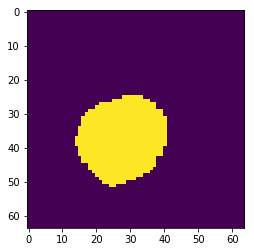

In [187]:
plt.imshow(contour_experts[0].reshape(64,64))

In [171]:
model = Sequential()
model.add(Dense(100, kernel_regularizer=regularizers.l2(3*0.001), input_shape=[input_AE.shape[1]]))
model.add(Dense(4096, kernel_regularizer=regularizers.l2(3*0.001)))
#model.add(Dense(4096,  input_shape=[l2.shape[1]*l2.shape[2]]))
#model.add(Dense(100, input_shape=[l2.shape[1]]))

In [172]:
for p in model.layers:
    print(p.name, p.input_shape, p.output_shape)

dense_15 (None, 4096) (None, 100)
dense_16 (None, 100) (None, 4096)


In [173]:
model.compile(loss='mean_squared_error',
              optimizer='adam',
              metrics=['accuracy'])

In [174]:
h2 = model.fit(input_x, input_y, epochs=100, verbose=2)

Epoch 1/100
0s - loss: 186261.1348 - acc: 0.0000e+00
Epoch 2/100
0s - loss: 10762.3609 - acc: 0.0000e+00
Epoch 3/100
0s - loss: 2545.9757 - acc: 0.0000e+00
Epoch 4/100
0s - loss: 841.0118 - acc: 0.0000e+00
Epoch 5/100
0s - loss: 489.6343 - acc: 0.0000e+00
Epoch 6/100
0s - loss: 493.8493 - acc: 0.0000e+00
Epoch 7/100
0s - loss: 389.3375 - acc: 0.0000e+00
Epoch 8/100
0s - loss: 347.5178 - acc: 0.0000e+00
Epoch 9/100
0s - loss: 195.5305 - acc: 0.0000e+00
Epoch 10/100
0s - loss: 284.0991 - acc: 0.0000e+00
Epoch 11/100
0s - loss: 1237.2119 - acc: 0.0000e+00
Epoch 12/100
0s - loss: 866.0362 - acc: 0.0000e+00
Epoch 13/100
0s - loss: 238.1484 - acc: 0.0000e+00
Epoch 14/100
0s - loss: 268.4109 - acc: 0.0000e+00
Epoch 15/100
0s - loss: 196.3284 - acc: 0.0000e+00
Epoch 16/100
0s - loss: 163.1478 - acc: 0.0000e+00
Epoch 17/100
0s - loss: 167.2324 - acc: 0.0000e+00
Epoch 18/100
0s - loss: 178.3349 - acc: 0.0000e+00
Epoch 19/100
0s - loss: 215.0888 - acc: 0.0000e+00
Epoch 20/100
0s - loss: 161.8898 

Text(0.5,0,'epochs')

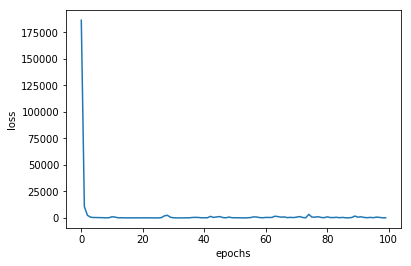

In [175]:
metric = 'loss'
plt.plot(range(len(h2.history[metric])), h2.history[metric])
plt.ylabel(metric)
plt.xlabel('epochs')

In [176]:
l3_pred = model.predict(input_x)

In [177]:
pred3 = l3_pred[0].reshape(64, 64)

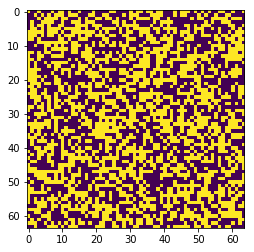

In [178]:
j = 17
# select one predicted ROI
pred3 = l3_pred[j].reshape((64,64))
p = cv2.threshold(pred3, 0, 1, cv2.THRESH_BINARY)
plt.imshow(p[1])

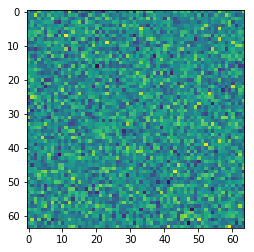

In [179]:
plt.imshow(pred3)

2e stacked auto encoder ne fonctionne pas

In [ ]:
#opt_solution   = scipy.optimize.minimize(encoder1.sparseAutoencoderCost, encoder1.theta, 
#                                             args = (train_data,), method = 'L-BFGS-B', 
#                                             jac = True, options 